# Define your ouwn data generator    
## It choses a batch of images from the training data folder
## It applies augmentation on each of the images
## It crops a random patch from each of the augmented data, following a certain pdf distribution (if given)

    

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tensorflow==2.0.0
!pip install SimpleITK

     |████████████████████████████████| 86.3MB 50kB/s 
     |████████████████████████████████| 450kB 57.9MB/s 
     |████████████████████████████████| 3.8MB 54.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ff0ec4ceebfc5ab7012ee30f8d8839ec248a2b30832b2cdcb98a4aa5734614a5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1

In [0]:
import os
os.chdir("/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/MU_Lux_CZ")
# !pip3 install -r requirements.txt

In [0]:
import numpy as np
import skimage
import skimage.morphology
import cv2
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# print(keras.__version__)
# Follow: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
## Define random crop function
def random_crop(x, y,y_marks,weights, random_crop_size_input, random_crop_size_output, pdf=1, sync_seed=None):
    """
    x is 2D data
    pdf is a 2D image representing the sampling distribution to crop the patches
    """    
    np.random.seed(sync_seed)
    w, h = x.shape[1], x.shape[0]
#     rangew = (w - random_crop_size[0])
#     rangeh = (h - random_crop_size[1])
    rangew = (w - np.floor(random_crop_size_input[0]//2))
    rangeh = (h - np.floor(random_crop_size_input[1]//2))
#     offsetw = 0 if rangew == 0 else np.random.randint(rangew)
#     offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    if pdf == 1:
        offsetw = np.random.randint(np.floor(random_crop_size_input[0]//2), rangew)
        offseth = np.random.randint(np.floor(random_crop_size_input[1]//2), rangeh)
    else:
        l = np.int(np.floor(random_crop_size_input[0]//2))
        u = np.int(np.floor(random_crop_size_input[1]//2))
        pdf_im = np.ones(y.shape)
        pdf_im[y>0]=pdf
        pdf_im = pdf_im[l:-l,u:-u]
        prob = np.float32(pdf_im)
        prob = prob.ravel()/np.sum(prob)
        choices = np.prod(pdf_im.shape)
        index = np.random.choice(choices, size=1,p = prob)
        coordinates = np.unravel_index(index, shape=pdf_im.shape)
        offsetw = coordinates[0][0] # pdf first coordinate corresponds to the "x" axis = width
        offsetw = offsetw + l
        offseth = coordinates[1][0] # pdf second coordinate corresponds to the "y" axis = height
        offseth = offseth + u
    
    lr = offsetw-np.floor(random_crop_size_input[0]//2)
    lr = lr.astype(np.int)
    ur = offsetw+np.round(random_crop_size_input[0]//2)
    ur = ur.astype(np.int)
    
    lc = offseth-np.floor(random_crop_size_input[1]//2)
    lc = lc.astype(np.int)
    uc = offseth+np.round(random_crop_size_input[1]//2)
    uc = uc.astype(np.int)
    
    x_patch = x[lr:ur,lc:uc]
    
    y_patch = y[lr:ur,lc:uc]
    y_marks_patch = y_marks[lr:ur,lc:uc]
    weights_patch = weights[lr:ur,lc:uc]
    if random_crop_size_input != random_crop_size_output:
      y_patch=center_crop(y_patch, random_crop_size_output)
      y_marks_patch=center_crop(y_marks_patch, random_crop_size_output)
      weights_patch=center_crop(weights_patch, random_crop_size_output)

#     lr = offsetw-np.floor(random_crop_size_output[0]//2)
#     lr = lr.astype(np.int)
#     ur = offsetw+np.round(random_crop_size_output[0]//2)
#     ur = ur.astype(np.int)
    
#     lc = offseth-np.floor(random_crop_size_output[1]//2)
#     lc = lc.astype(np.int)
#     uc = offseth+np.round(random_crop_size_output[1]//2)
#     uc = uc.astype(np.int)    
    return x_patch, y_patch, y_marks_patch, weights_patch
    
def center_crop(x, crop_size):
    """
    Crop function when there is no padding in the the CNN and we need to reduce the ground truth. 
    x is 3D data but patches are only cropped in 2D. x dimensions (z,y,x)
    """    
    halfh = (x.shape[0]-crop_size[0])//2
    halfw = (x.shape[1]-crop_size[1])//2

    return x[halfh:-halfh,halfw:-halfw] 

## Define data augmentation for the case in which x has dimensions (t,i,j) and y (1,i,j). 
# The output of this function are augmented_x with dimensions (1,t,i,j,c) and augmented_y with (1,1,i,j,c)

def data_augmentation_weightedmaps(x, y, y_marks, y_weights, self, seed = None):
      
    data_gen_args = dict(rotation_range=self.rotation_range,
                            width_shift_range=self.width_shift_range,
                            height_shift_range=self.height_shift_range,
                            shear_range=self.shear_range,
                            zoom_range=self.zoom_range,
                            horizontal_flip=self.horizontal_flip,
                            fill_mode=self.fill_mode) 

    # Initialize Keras data augmentaiton
    image_datagen = ImageDataGenerator(**data_gen_args)
    weight_datagen = ImageDataGenerator(**data_gen_args)
    mark_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Apply the same data augmentation to all the images, corresponding mask, 
    # marks, weights and pdf for cropping
    # self.dim_input=(220,220)

    input_channel = np.zeros((1,self.dim_input[0], self.dim_input[1]))
    weights_channel = np.zeros((1,self.dim_output[0], self.dim_output[1]))
    output_channel = np.zeros((1,self.dim_output[0], self.dim_output[1]))
    marks_channel = np.zeros((1,self.dim_output[0], self.dim_output[1]))
    
    
    # Generate the same seed:
    seed = np.random.randint(10000000)       
    # if self.module == "train":
    augmented_x = np.zeros((x.shape[0], x.shape[1]))
#             augmented_y = np.zeros((y.shape[0], y.shape[1], y.shape[2]))
    
    # self_pdf = self.pdf
    
    # if self_pdf == None:
    #     self_pdf = np.ones((x.shape[0], x.shape[1]))
    # augmented_pdf = np.zeros((1,self_pdf.shape[0], self_pdf.shape[1], 1))
    
    x = x.reshape((1, x.shape[0], x.shape[1], 1))
    for batch in image_datagen.flow(x,  batch_size=1, seed = seed):
        augmented_x = batch[0,:,:,0]
        break
    # Apply the same data augmentation to the ground truth. 
    # GROUND TRUTH IS ASSUMED TO BE 2D
    # self.dim_output=(36,36)
    # output_channel.dimensions = (1,36,36)
    aux_y = np.copy(y)
    aux_y = aux_y.reshape((1, y.shape[0], y.shape[1], 1))
    for batch in mask_datagen.flow(aux_y,  batch_size=1, seed = seed):
        augmented_y = batch[0,:,:,0]
        break

    aux_y_marks = np.copy(y_marks)
    aux_y_marks = aux_y_marks.reshape((1, y_marks.shape[0], y_marks.shape[1], 1))
    for batch in mask_datagen.flow(aux_y_marks, batch_size=1, seed = seed):
        augmented_y_marks = batch[0,:,:,0]
        break

    aux_weights = np.copy(y_weights)
    aux_weights = aux_weights.reshape((1, y_weights.shape[0], y_weights.shape[1], 1))
    for batch in mask_datagen.flow(aux_weights,  batch_size=1, seed = seed):
        augmented_weights = batch[0,:,:,0]
        break

    # aux_pdf = np.copy(self_pdf)
    # aux_pdf = aux_pdf.reshape((1, self_pdf.shape[0], self_pdf.shape[1],1))
    # for batch in mask_datagen.flow(aux_pdf,  batch_size=1, seed = seed):
    #     augmented_pdf = batch
    #     break
            
    augmented_y[augmented_y>0]=1
    augmented_y_marks[augmented_y_marks>0]=1
    
    random_crop_size_input = (self.dim_input[0],  self.dim_input[1])
    random_crop_size_output = (self.dim_output[0],  self.dim_output[1])

    input_im,output_labels,output_marks,weights = random_crop(augmented_x,augmented_y,augmented_y_marks,augmented_weights, random_crop_size_input, random_crop_size_output, pdf=self.pdf, sync_seed=seed)

    return input_im, output_labels, output_marks, weights


# Follow: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

## Define DataGenerator 
def median_normalization(image):
    '''
    Normalize the values in the image to have median 0.5
    '''
    # image_ = image / 255 + (.5 - np.median(image / 255)) # Original from MU-Lux_CZ
    # The function assumes that values are in the [0,1] range
    image_ = image + (.5 - np.median(image))
    return np.maximum(np.minimum(image_, 1.), .0)

def hist_equalization(image):
    """
    Contrast limited adaptive histogram equalization for normalization fo values
    """
    # return cv2.equalizeHist(image) / 255 # Original from MU-Lux_CZ
    # The function assumes that values are in the [0,1] range
    return cv2.equalizeHist(image)

def mean_normalization(image):
    '''
    Normalize the values in the image to have mean 0.5
    '''
    # The function assumes that values are in the [0,1] range
    image_ = image + (.5 - np.mean(image))
    return np.maximum(np.minimum(image_, 1.), .0)

def get_normal_fce(normalization):
    '''
    selects the corresponding normalizing function
    '''
    if normalization == 'HE':
        return hist_equalization
    if normalization == 'MEDIAN':
        return median_normalization
    if normalization == 'MEAN':
        return mean_normalization
    else:
        error('normalization function was not picked')
        return None

def remove_uneven_illumination(img, blur_kernel_size=501, data_type='uint16'):
    '''
    uses LPF to remove uneven illumination
    '''

    img_f = img.astype(np.float32)
    img_mean = np.mean(img_f)

    img_blur = cv2.GaussianBlur(img_f, (blur_kernel_size, blur_kernel_size), 0)
    if data_type == 'uint16':
        result = np.maximum(np.minimum((img_f - img_blur) + img_mean, 65535), 0).astype(np.int32)
        return result
    elif datatype == 'uint8':
        result = np.maximum(np.minimum((img_f - img_blur) + img_mean, 255), 0).astype(np.int32)
        return result
    else:
        error('Unknown datatype {}'.format(data_type))
        return None

def read_instances(path, radious=5):
    '''
    Reads the instance segmentations and returns a binary mask and the marks for the detections.
    '''
    labels = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    mi = labels.shape[0]
    ni = labels.shape[1]

    if np.sum(labels) > 0:
        # Obtain the instances
        components = np.unique(labels)
        n_comp = len(components) - 1
        detection_marks = np.zeros((n_comp, mi, ni))
        for c in range(n_comp):
            # Only keeps current object.
            tmp = (labels == components[c + 1])
            # Transform the label with erosion
            diskelem = skimage.morphology.disk(radious)
            detection_marks[c] = skimage.morphology.binary_erosion(tmp, diskelem)
        detection_marks = np.sum(detection_marks, axis=0)
        detection_marks = detection_marks.reshape((mi, ni))
    else:
        detection_marks = np.zeros((mi, ni))
    labels[labels > 0] = 1
    return labels, detection_marks

def read_input_image(path, normalization='MEAN', uneven_illumination=False):
  normalization_fce = get_normal_fce(normalization)
  im = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
  
  mi = im.shape[0]
  ni = im.shape[1]
  if im is None:
      print('image {} was not loaded'.format(name))

  if uneven_illumination:
      # o = np.minimum(o, 255).astype(np.uint8) # Original from MU-Lux_CZ
      im = remove_uneven_illumination(im, data_type=im.dtype.name)

  # convert values to the [0,1] range
  if im.dtype.name == 'uint16':
    im = im.astype(np.float32)
    im = im / 65535
  else:
    im = im.astype(np.float32)
    im = im / 255
  
  im = normalization_fce(im)

  return im

class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,list_IDs, dataset_path, rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, horizontal_flip, fill_mode, dim_input=None, dim_output=None, pdf=1, module="train", instance_radious=5, patch_batch=1, batch_size=5, shuffle=True):
        # Suffle is used to take everytime a different sample from the list in a random way so the training order differs. 
        #     # we create two instances with the same arguments
        # 'Initialization'

            
        self.list_IDs = list_IDs
        
#         if module=='Train':
#             self.dataset_path = '../data/training/'
#         else:
#             self.dataset_path = '../data/test/'

        self.dataset_path = dataset_path   
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        
        self.fill_mode = fill_mode       
        self.pdf = pdf
        self.module = module # "Train" or "Test"    
        self.instance_radious = instance_radious    
#         self.data_format = data_format
        if dim_input == None:
            dim_input =(512,512)
        if dim_output == None:
            dim_output=(512,512)
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.patch_batch = patch_batch
        self.batch_size = batch_size
        self.shuffle = shuffle # #
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # print(index)
        # print(self.indexes)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # print(indexes)
        # Generate data
        x,y = self.__data_generation(list_IDs_temp)
        return x,y
        # Generate data
        # x = self.__data_generation(list_IDs_temp)
        # return x
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)    
    # crop patches

    def __data_generation(self, list_IDs_temp):
        
        # 'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialization
        x = np.empty((self.batch_size*self.patch_batch, self.dim_input[0],  self.dim_input[1],1))
        w = np.empty((self.batch_size*self.patch_batch, self.dim_input[0],  self.dim_input[1],1))
        y = np.empty((self.batch_size*self.patch_batch, self.dim_output[0],  self.dim_output[1], 1))

        # Generate data
        j = 0
        if self.module == 'train':
          for patch in range(self.patch_batch):                        
              for i, ID in enumerate(list_IDs_temp):
                # Store sample
                # print(ID)
                # ID = list_IDs_temp[0]
                ID = ID.split('_')[-1].split('.')[0]
                # print(ID)
                # print("{0}/inputs/raw_{1}.tif".format(self.dataset_path, ID))
                aux_x = read_input_image("{0}/inputs/raw_{1}.tif".format(self.dataset_path, ID))
                aux_y,aux_y_marks = read_instances("{0}/labels/instance_ids_{1}.tif".format(self.dataset_path, ID), radious=self.instance_radious)
                aux_y_weights = cv2.imread("{0}/weights/instance_ids_{1}_weight.tif".format(self.dataset_path, ID), cv2.IMREAD_ANYDEPTH)
                augmented_x, augmented_y, augmented_y_marks, augmented_weights = data_augmentation_weightedmaps(aux_x, aux_y, aux_y_marks, aux_y_weights, self)             
                x[j,:,:,0] = augmented_x
                w[j,:,:,0] = augmented_weights

                # Store ground truth
                augmented_y[augmented_y>0] = 1
                # augmented_y_marks[augmented_y_marks>0] = 1
                y[j,:,:,0] = augmented_y
              # y[j,:,:,1] = 1-augmented_y
              # y[j,:,:,2] = augmented_y_marks
              # y[j,:,:,3] = 1-augmented_y_marks
                j += 1 

        elif self.module == 'test':
          for patch in range(self.patch_batch):                        
              for i, ID in enumerate(list_IDs_temp):
                ID = ID.split('_')[-1].split('.')[0]
                # print("{0}/inputs/raw_{1}.tif".format(self.dataset_path, ID))
                aux_x = read_input_image("{0}/inputs/raw_{1}.tif".format(self.dataset_path, ID))
                aux_y,aux_y_marks = read_instances("{0}/labels/instance_ids_{1}.tif".format(self.dataset_path, ID), radious=self.instance_radious)
                # Get random crops

                input_im,output_labels,output_marks,weights = random_crop(aux_x,aux_y,aux_y_marks,aux_y, (self.dim_input[0],  self.dim_input[1]), (self.dim_output[0],  self.dim_output[1]), pdf=self.pdf)
                # plt.figure(figsize=(15,10))
                # plt.subplot(2,2,1)
                # plt.imshow(aux_x)
                # plt.subplot(2,2,2)
                # plt.imshow(aux_y)
                # plt.subplot(2,2,3)
                # plt.imshow(input_im)
                # plt.subplot(2,2,4)
                # plt.imshow(output_labels)
                # plt.show()
                x[j,:,:,0] = input_im
                w[j,:,:,0] = weights

                # Store ground truth
                output_labels[output_labels>0] = 1
                output_marks[output_marks>0] = 1
                y[j,:,:,0] = output_labels
              # y[j,:,:,1] = 1-output_labels
              # y[j,:,:,2] = output_marks
              # y[j,:,:,3] = 1-output_marks
                j += 1

        x = x.astype(np.float32)
        w = w.astype(np.float32)
        y = y.astype(np.float32)
        # return [x,w,y]
        return [x,w],y
        # return x,y


## Try your data generator

In [0]:
import matplotlib.pyplot as plt
import glob
DATASET_PATH = "/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/data/train/stack2im"
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'pdf': 5000,
          'fill_mode': 'reflect',
          'patch_batch': 2,
          'batch_size': 5,
          'module': 'train'}
files4training = os.listdir(DATASET_PATH + '/inputs/')
files4training.sort()

partition ={'train': files4training}
self = DataGenerator(partition['train'],**params)

data = self.__getitem__(1)

# ID = 'raw_001.tif'

# aux_x = read_input_image(self.dataset_path + '/inputs/'+ ID)

# aux_y,aux_y_marks = read_instances(self.dataset_path + '/labels/'+ ID, radious=self.instance_radious)

# aux_y_weights = cv2.imread(self.dataset_path + '/weights/'+ ID, cv2.IMREAD_ANYDEPTH)

# seed = np.random.randint(100000)
# random_crop_size_input = (512,512)
# random_crop_size_output = (512,512)
# c = 0
# input_im,output_labels,output_marks,weights = random_crop(aux_x, aux_y,aux_y_marks,aux_y_weights, random_crop_size_input, random_crop_size_output, sync_seed=seed)
for i in range(data[1].shape[0]):
  plt.figure(figsize=(10,10))
  plt.subplot(2,2,1)
  plt.imshow(data[0][0][i,:,:,0])
  plt.subplot(2,2,2)
  plt.imshow(data[0][1][i,:,:,0])
  plt.subplot(2,2,3)
  plt.imshow(data[1][i,:,:,0])
  plt.subplot(2,2,4)
  plt.imshow(data[1][i,:,:,0])
  plt.show()


# Define a U-Net with weighted loss

## Define weighted losses


In [0]:
from tensorflow.keras import backend as K

# weight: weighted tensor(same shape with mask image)
def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
    weighted_dice_loss(y_true, y_pred, weight)
    return loss

def binary_crossentropy_weighted(weights):

  def loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weights - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))

    return K.sum(loss) / K.sum(weight)

  return loss

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

# def binary_crossentropy_weighted(weights):
#   """
#   Custom binary cross entropy loss. The weights are used to multiply
#   the results of the usual cross-entropy loss in order to give more weight
#   to areas between cells close to one another.

#   The variable 'weights' refers to input weight-maps.
#   """

#   def loss(y_true, y_pred):
#     return K.mean(weights * K.binary_crossentropy(y_true, y_pred), axis=-1)

#   return loss

# def weighted_binary_loss(X):
#     y_pred, weights, y_true = X
#     loss = tensorflow.keras.losses.binary_crossentropy(y_pred, y_true)
#     loss = tensorflow.keras.layers.multiply([loss, weights])
#     return loss

# def identity_loss(y_true, y_pred):
#     return K.mean(y_pred, axis=-1)

def weighted_BCE(weights):
  # https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
  def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
      y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

      return K.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    # pos_weight = beta / (1 - beta)
    # pos_weight = beta / (1 - beta) + tf.exp(-tf.pow(weights, 2))
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=weights)

    # or reduce_sum and/or axis=-1
    # return tf.reduce_mean(loss * (1 - beta))
    return tf.reduce_mean(loss)

  return loss

# def weighted_mse(weights):
#   """
#   Custom mean squared error loss. The weights are used to multiply
#   the results of the usual mse loss in order to give more weight
#   to areas between cells close to one another or to the contours

#   The variable 'weights' refers to input weight-maps.
#   """
#   def loss(y_true, y_pred):
#     S = K.sum(weights * K.square(y_pred-y_true), axis=-1)
#     factor = K.sum(0.5*weights,axis=-1)
#     return K.sum(S / factor, axis=-1)

#   return loss

## first way of getting a unet with tf 2.0.0

In [0]:
import tensorflow.keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
# from tensorflow.tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error

def create_model(mi=256, ni=256, lr = 0.0001):
  """
  Weighted U-Net architecture.

  The tuple 'input_size' corresponds to the size of the input images and labels.
  Default value set to (512, 512, 1) (input images size is 512x512).
  """
  # TODO: change if using `channels_first` image data format
  input_img = Input(shape=(mi, ni, 1))
  # Get weights.
  # weights = Input(shape=(mi, ni, 1))
  # Downsampling path
  c1e = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(input_img)
  c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1e)
  p1 = MaxPooling2D((2, 2), padding='same')(c1)

  c2e = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Conv2D(64, (3, 3), activation='elu',  kernel_initializer='he_normal', padding='same')(c2e)
  p2 = MaxPooling2D((2, 2), padding='same')(c2)

  c3e = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3e)
  p3 = MaxPooling2D((2, 2), padding='same')(c3)

  c4e = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4e)
  p4 = MaxPooling2D((2, 2), padding='same')(c4)

  c5e = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5e)

  # Upsampling path
  u4 = UpSampling2D((2, 2), interpolation='bilinear')(c5)
  a4 = Concatenate(axis=3)([u4, c4])
  c6e = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(a4)
  c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6e)

  u3 = UpSampling2D((2, 2), interpolation='bilinear')(c6)
  a3 = Concatenate(axis=3)([u3, c3])
  c7e = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(a3)
  c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7e)

  u2 = UpSampling2D((2, 2), interpolation='bilinear')(c7)
  a2 = Concatenate(axis=3)([u2, c2])
  c8e = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(a2)
  c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8e)

  u1 = UpSampling2D((2, 2), interpolation='bilinear')(c8)
  a1 = Concatenate(axis=3)([u1, c1])
  c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(a1)

  c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

  # Softmax
  # markers = Conv2D(2, (1, 1), activation='softmax', padding='same')(c10)
  c11 = Conv2D(2, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c10)
  cell_mask = Conv2D(1, (1, 1), activation='softmax', kernel_initializer='he_normal', padding='same')(c11)
  # output = Concatenate(axis=3, name='output')([markers, cell_mask])

  # Specify input (image + weights) and output.
  # model = Model(inputs=[input_img,weights], outputs=output)
  model = Model(inputs=input_img, outputs=cell_mask)
  # Use Adam optimizer, custom weighted mean squared error loss and specify metrics
  # Also use weights inside the loss function.
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  # model = Model(input_img, output)
  print('U-Net model was created')
  return model




## second way of getting a unet with tf 2.0.0
https://www.kaggle.com/advaitsave/tensorflow-2-nuclei-segmentation-unet

## binary weighted loss example
https://stackoverflow.com/questions/48555820/keras-binary-segmentation-add-weight-to-loss-function/48577360

https://stackoverflow.com/questions/55213599/u-net-with-pixel-wise-weighted-cross-entropy-input-dimension-errors

https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [0]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from functools import partial

import tensorflow as tf

def create_model(mi=256, ni=256, lr = 0.0001):
  """
  Weighted U-Net architecture.

  The tuple 'input_size' corresponds to the size of the input images and labels.
  Default value set to (512, 512, 1) (input images size is 512x512).
  """

  # Build U-Net model
  inputs = Input((mi,ni,1))
  # Get weights.
  # weights = Input((mi, ni, 1))
  # # Get true masks
  # true_masks = Input((mi, ni, 1))

  c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = BatchNormalization()(c1)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  c1 = BatchNormalization()(c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = BatchNormalization()(c2)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  c2 = BatchNormalization()(c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = BatchNormalization()(c3)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  c3 = BatchNormalization()(c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = BatchNormalization()(c4)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  c4 = BatchNormalization()(c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = BatchNormalization()(c5)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
  c5 = BatchNormalization()(c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = BatchNormalization()(c6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
  c6 = BatchNormalization()(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = BatchNormalization()(c7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
  c7 = BatchNormalization()(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = BatchNormalization()(c8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
  c8 = BatchNormalization()(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = BatchNormalization()(c9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
  c9 = BatchNormalization()(c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  # loss = partial(loss_function, weights)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate=lr, name='adam'), loss=weighted_bce_dice_loss, metrics=['accuracy'])

  # Use a lambda layer to calculate the weighted loss 
  # loss = Lambda(weighted_binary_loss, output_shape=(mi, ni, 1))([outputs, weights, true_masks])
  # model = Model(inputs=[inputs, weights, true_masks], outputs=loss)
  # model.compile(optimizer=Adam(learning_rate=lr, name='adam'), loss=identity_loss, metrics=['accuracy'])


  # Specify input (image + weights) and output.
  # model = Model(inputs=[inputs,weights], outputs=outputs)
  # model.compile(optimizer=Adam(learning_rate=lr,name='adam'), loss=binary_crossentropy_weighted(weights), metrics=['accuracy'])
  # model = Model(inputs=[inputs], outputs=[outputs])
  # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  print('U-Net model was created')
  return model

# Use a common U-Net structure

In [0]:
# Create U-Net for super-resolution
from keras.models import Model
from keras.layers import Input, UpSampling2D
from keras.layers import Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D
from keras.layers import concatenate
from keras.optimizers import Adam

inputs = Input((512, 512, 1))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = AveragePooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = AveragePooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = AveragePooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

outputs = Conv2D(2, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
# compile the model with RMSProp as optimizer, MSE as loss function and MAE as metric
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['mean_absolute_error'])
model.summary()

RuntimeError: ignored

In [0]:
model.get_config()

# Train the model

## Evaluate the data generator

In [0]:
DATASET_PATH = "/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/data/train/stack2im"
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'pdf': 5000,
          'fill_mode': 'reflect',          
          'dim_input': (256,256),
          'dim_output': (256,256),
          'patch_batch': 2,
          'batch_size': 1
          }
files4training = os.listdir(DATASET_PATH + '/inputs/')
files4training.sort()

partition ={'train': files4training}

# Generators
self = DataGenerator(partition['train'],**params)
data = self.__getitem__(30)
for i in range(data[1].shape[0]):
  plt.figure(figsize=(10,10))
  plt.subplot(2,2,1)
  plt.imshow(data[0][0][i,:,:,0])
  plt.subplot(2,2,2)
  plt.imshow(data[0][1][i,:,:,0])
  plt.subplot(2,2,3)
  plt.imshow(data[1][i,:,:,0])
  plt.subplot(2,2,4)
  plt.imshow(data[1][i,:,:,0])
  plt.show()

## Create the model

In [0]:
model = create_model(mi=256, ni=256, lr = 0.001)

In [0]:
model.load_weights('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/checkpoints/2dUnet_weights_00004.hdf5')

## Train the model

In [10]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt
import SimpleITK as sitk
# from my_classes import DataGenerator

DATASET_PATH = "/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/data/train/stack2im"
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'pdf': 5000,
          'fill_mode': 'reflect',          
          'dim_input': (256,256),
          'dim_output': (256,256),
          'patch_batch': 1,
          'batch_size': 1,
          'module': 'train'
          }
files4training = os.listdir(DATASET_PATH + '/inputs/')
files4training.sort()

TEST_PATH = "/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/data/test/stack2im"
params_test = {'dataset_path': TEST_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'pdf': 5000,
          'fill_mode': 'reflect',          
          'dim_input': (256,256),
          'dim_output': (256,256),
          'patch_batch': 1,
          'batch_size': 10,
          'module': 'test'
          }
files4test = os.listdir(TEST_PATH + '/inputs/')
files4test.sort()

partition ={'train': files4training,
            'test': files4test}

# Generators
training_generator = DataGenerator(partition['train'],**params)
test_generator = DataGenerator(partition['test'],**params_test)
test_data = test_generator.__getitem__(1)
for j in range(len(test_data[1])):
    sitk.WriteImage(sitk.GetImageFromArray(test_data[1][j,:,:,0].astype(np.uint8)),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/gt_{0}.tif".format(np.str(j)))
    sitk.WriteImage(sitk.GetImageFromArray(test_data[0][0][j,:,:,0]),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/input_{0}.tif".format(np.str(j)))



# # Train model on dataset
# model = create_model(mi=256, ni=256, lr = 0.0001)
# model.optimizer.get_config()
# model.summary()

callbacks = []
checkpoint = ModelCheckpoint('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/checkpoints/2dUnet_weights_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=True, mode='auto', save_freq=20)
if not os.path.exists('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/checkpoints/'):
        os.makedirs('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/checkpoints/')
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/logs', write_graph=True,# write_grads=True, batch_size=1, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

# numEpochs = 50
# earlystopper = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)
# earlystopper.set_model(model)
# callbacks.append(earlystopper)

reducelearning = ReduceLROnPlateau(monitor='lr', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

# Fit model
# earlystopper = EarlyStopping(patience=15, verbose=1)
# checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
for i in range(19):
  # data = training_generator.__getitem__(1)
  # X_train = data[0][0] # [0]
  # Y_train = data[1]
  # del data
  # model.fit(X_train, Y_train, batch_size=1, epochs=1, callbacks=callbacks)
  # model.fit(X_train,Y_train, batch_size=1, epochs=1, callbacks=callbacks)
  model.fit_generator(generator=training_generator, epochs=10, callbacks=callbacks) 
  # data = test_generator.__getitem__(1)
  # X_train = data[0][0] # [0]
  # Y_train = data[1]
  pred = model.predict(test_data[0][0])
  for j in range(pred.shape[0]):
    sitk.WriteImage(sitk.GetImageFromArray(pred[j,:,:,0]),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/prediction_CHANNEL1_{0}_{1}.tif".format(np.str(i), np.str(j)))
    # sitk.WriteImage(sitk.GetImageFromArray(pred[j,:,:,1]),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/prediction_epoch_CHANNEL2_{0}_{1}.tif".format(np.str(i), np.str(j)))
    # sitk.WriteImage(sitk.GetImageFromArray(Y_train[j,:,:,0].astype(np.uint8)),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/gt_{0}_{1}.tif".format(np.str(i), np.str(j)))
    # sitk.WriteImage(sitk.GetImageFromArray(X_train[j,:,:,0]),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/input_{0}_{1}.tif".format(np.str(i), np.str(j)))
  del pred
  # del X_train
  # del Y_train

Epoch 1/10
666/666 [==============================] - 5872s 9s/step - loss: 0.2403 - accuracy: 0.9945
Epoch 2/10
666/666 [==============================] - 1717s 3s/step - loss: 0.2498 - accuracy: 0.9938
Epoch 3/10
666/666 [==============================] - 1617s 2s/step - loss: 0.2173 - accuracy: 0.9945
Epoch 4/10
666/666 [==============================] - 1619s 2s/step - loss: 0.2282 - accuracy: 0.9942
Epoch 5/10
666/666 [==============================] - 1605s 2s/step - loss: 0.2351 - accuracy: 0.9940
Epoch 6/10
666/666 [==============================] - 1582s 2s/step - loss: 0.2242 - accuracy: 0.9934
Epoch 7/10
666/666 [==============================] - 1576s 2s/step - loss: 0.2153 - accuracy: 0.9951
Epoch 8/10
666/666 [==============================] - 1610s 2s/step - loss: 0.1781 - accuracy: 0.9951
Epoch 9/10
666/666 [==============================] - 1641s 2s/step - loss: 0.1836 - accuracy: 0.9950
Epoch 10/10
666/666 [==============================] - 1722s 3s/step - loss: 0.169

KeyboardInterrupt: ignored

In [0]:
  pred = model.predict(test_data[0][0])
  for j in range(pred.shape[0]):
    sitk.WriteImage(sitk.GetImageFromArray(pred[j,:,:,0]),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/prediction_CHANNEL1_{0}_{1}.tif".format(np.str(i), np.str(j)))
    # sitk.WriteImage(sitk.GetImageFromArray(pred[j,:,:,1]),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/prediction_epoch_CHANNEL2_{0}_{1}.tif".format(np.str(i), np.str(j)))
    # sitk.WriteImage(sitk.GetImageFromArray(Y_train[j,:,:,0].astype(np.uint8)),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/gt_{0}_{1}.tif".format(np.str(i), np.str(j)))
    # sitk.WriteImage(sitk.GetImageFromArray(X_train[j,:,:,0]),"/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/MU_Lux_CZ/binary001/input_{0}_{1}.tif".format(np.str(i), np.str(j)))
  del pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: 'shape' argument should be used instead of 'dims'


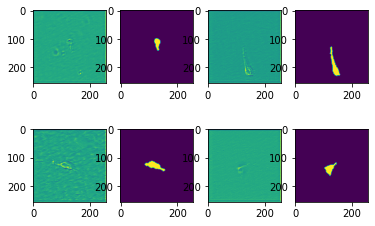

In [0]:


  # plt.figure()
  # plt.subplot(2,4,1)
  # plt.imshow(pred[0,:,:,0])
  # plt.subplot(2,4,2)
  # plt.imshow(data[1][0,:,:,0])
  # plt.subplot(2,4,3)
  # plt.imshow(pred[1,:,:,0])
  # plt.subplot(2,4,4)
  # plt.imshow(data[1][1,:,:,0])
  # plt.subplot(2,4,5)
  # plt.imshow(pred[2,:,:,0])
  # plt.subplot(2,4,6)
  # plt.imshow(data[1][2,:,:,0])
  # plt.subplot(2,4,7)
  # plt.imshow(pred[3,:,:,0])
  # plt.subplot(2,4,8)
  # plt.imshow(data[1][3,:,:,0])

import matplotlib.pyplot as plt
data = training_generator.__getitem__(30)
pred = model.predict(data[0][:4])
plt.figure()
plt.subplot(2,4,1)
plt.imshow(pred[0,:,:,1])
plt.subplot(2,4,2)
plt.imshow(data[1][0,:,:,0])
plt.subplot(2,4,3)
plt.imshow(pred[1,:,:,1])
plt.subplot(2,4,4)
plt.imshow(data[1][1,:,:,0])
plt.subplot(2,4,5)
plt.imshow(pred[2,:,:,1])
plt.subplot(2,4,6)
plt.imshow(data[1][2,:,:,0])
plt.subplot(2,4,7)
plt.imshow(pred[3,:,:,1])
plt.subplot(2,4,8)
plt.imshow(data[1][3,:,:,0])

In [0]:
p = model.predict(data[0])
for i in range(data[1].shape[0]):

  plt.imshow(p[i,:,:,1])
  plt.show()

In [0]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}

# Generators
training_generator = DataGenerator(partition['train'],**params)

# Train model on dataset
model = get_unet(220,220,21,3,0.0001,'binary_crossentropy', 'Adam', 'accuracy', 32, 1254)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_weights_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=True, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

model.fit_generator(generator=training_generator, epochs=1000, callbacks=callbacks)

In [0]:
import numpy as np
from convolutional_networks import get_unet, get_unet_nopadding
from keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
dim_input=(220,220,21)
x = dim_input[0]
y = 2*(2*(2*(2*(0.5*(0.5*(0.5*(0.5*(x-4)-4)-4)-4)-4)-4)-4)-4)-4
y = np.int(y)
dim_output=(y,y,1)
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5,
          'dim_input': dim_input,
          'dim_output': dim_output}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}

# Train model on dataset
model = get_unet_nopadding(220,220,21,3,0.0001,'binary_crossentropy', 'Adam', 'accuracy', 32, 1254)

# Generators
training_generator = DataGenerator(partition['train'],**params)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_nopadding_weights_01_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=False, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=2, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

# model.load_weights("./binary001/checkpoints/2dUnet_weights_00160.hdf5")

# model.fit_generator(generator=training_generator, epochs=2, callbacks=callbacks, verbose=2)

In [0]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
dim_input=(220,220,21)
x = dim_input[0]
y = 2*(2*(2*(2*(0.5*(0.5*(0.5*(0.5*(x-4)-4)-4)-4)-4)-4)-4)-4)-4
dim_output=(y,y,1)
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5
          'dim_input': dim_input,
          'dim_ouput': dim_ouput}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}

# Train model on dataset
model = get_unet(220,220,21,3,0.0001,'binary_crossentropy', 'Adam', 'accuracy', 32, 1254)

# Generators
training_generator = DataGenerator(partition['train'],**params)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_weights_01_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=False, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=2, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

model.load_weights("./binary001/checkpoints/2dUnet_weights_00160.hdf5")

model.fit_generator(generator=training_generator, epochs=(1000-160), callbacks=callbacks, verbose=2)

In [0]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}
model = load_model("./binary001/checkpoints/2dUnet_weights_01_00060.hdf5")
# Generators
training_generator = DataGenerator(partition['train'],**params)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_weights_02_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=False, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=2, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

model.fit_generator(generator=training_generator, epochs=(1000-160-60), callbacks=callbacks, verbose=2)

In [0]:
import matplotlib.pyplot as plt
self = DataGenerator(partition['train'],**params)

data = self.__getitem__(2)
self.dataset_path = DATASET_PATH
ID = 'video_10_000002.tif'
aux_x = sitk.ReadImage(self.dataset_path + '/input/input/'+ ID)
aux_x = sitk.GetArrayFromImage(aux_x)
aux_x = np.transpose(aux_x,[0,2,1]) # x dimensions (z,x,y)
aux_x = aux_x.reshape((aux_x.shape[0], aux_x.shape[1],aux_x.shape[2],1))

aux_y = sitk.ReadImage(self.dataset_path + '/output/output/'+ ID)
aux_y = sitk.GetArrayFromImage(aux_y)
aux_y = np.transpose(aux_y,[1,0]) # y dimensions (x,y)
aux_y = aux_y.reshape((1, aux_y.shape[0],aux_y.shape[1], 1))   

# plt.imshow(aux_x[10,:,:,0])
# plt.show()
# plt.imshow(aux_y[0,:,:,0])
# plt.show()
seed = np.random.randint(100000)
random_crop_size_input = (220,220)
random_crop_size_output = (208,208)
c = 0
input_channel, output_channel = random_crop(aux_x[:,:,:,c], aux_y[:,:,:,c], random_crop_size_input, random_crop_size_output, sync_seed=seed)
input_channel = (input_channel-np.min(input_channel))/(np.max(input_channel)-np.min(input_channel))

plt.imshow(input_channel[10,:,:])
plt.show()
plt.imshow(output_channel[0,:,:])
plt.show()

input_channel_i = np.transpose(input_channel,[1,2,0])
input_channel_i = input_channel_i.reshape((1, input_channel_i.shape[0], input_channel_i.shape[1], input_channel_i.shape[2]))
p = model.predict(input_channel_i)
plt.imshow(p[0,:,:,0])
plt.show()
